# Interactive Occlusion Heatmap slider for all models

For a given patient id the occlusion heatmap is calculated for all models and displayed in a slider.
The size of the occlusion can be adjusted manually.

### Imports

In [1]:
import os 
import pandas as pd
import numpy as np
import h5py
import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

#import functions_read_data as rdat
# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'


# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters
from functions.augmentation3d import zoom, rotate, flip, shift

2.2.0
/tf/notebooks/schnemau/xAI_stroke_3d


Using TensorFlow backend.


In [2]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl
import Utils_maurice as utils

In [3]:
which_split = 6
(train_idx, valid_idx, test_idx, X, X_train, X_valid, X_test, X_tab_train, X_tab_valid, X_tab_testt), (Y_train, Y_valid, Y_test), results, results2 = utils.read_and_split_img_data_andrea_maurice2(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split)

Y_train_MRS = to_categorical(Y_train)
Y_valid_MRS = to_categorical(Y_valid)
Y_test_MRS = to_categorical(Y_test)

### Load Data and Set Parameters

## Model

In [4]:
C = Y_train_MRS.shape[1]
batch_size = 5
ntrain = 325
nvalid = 40
ntest = 40

model_3d = ontram(utils.img_model_linear_final(np.expand_dims(X_train, axis = -1).shape[1:], 1))
model_3d.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])


# Occlusion without slider

In [5]:
results = pd.read_csv("/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/results_CIB.csv")
results

,p_idx,p_id,mrs,unfavorable,status,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,372,516.0,1.0,0,test,0.044105,0.023950,0.017395,0.004911,0.017696,0.021611,0.017479,0.11371,0,0.014348,0.086608,True
1,284,376.0,2.0,0,test,0.050286,0.054518,0.031816,0.017704,0.034485,0.037762,0.035194,0.11371,0,0.014883,0.091677,True
2,298,390.0,2.0,0,test,0.177475,0.150751,0.124391,0.057701,0.179366,0.137937,0.129488,0.11371,1,0.050163,0.425623,False
3,203,286.0,0.0,0,test,0.174663,0.218147,0.140748,0.136126,0.150853,0.164107,0.162076,0.11371,1,0.033675,0.269554,False
4,292,384.0,0.0,0,test,0.028673,0.024152,0.015896,0.003668,0.019326,0.018343,0.015132,0.11371,0,0.009523,0.040941,True
5,373,517.0,2.0,0,test,0.244437,0.338122,0.334070,0.239642,0.335218,0.298298,0.296115,0.11371,1,0.051406,0.437389,False
6,88,127.0,0.0,0,test,0.096855,0.203676,0.090252,0.075119,0.148151,0.122811,0.115751,0.11371,1,0.052890,0.451441,False
7,31,41.0,0.0,0,test,0.172877,0.146161,0.088933,0.139337,0.090259,0.127513,0.123718,0.11371,1,0.036816,0.299289,False
8,26,35.0,0.0,0,test,0.073977,0.055309,0.038755,0.025196,0.080130,0.054673,0.050478,0.11371,0,0.023148,0.169909,True
9,379,523.0,0.0,0,test,0.108577,0.106165,0.064636,0.059624,0.072459,0.082292,0.079940,0.11371,0,0.023362,0.171932,True


In [6]:
res_table = pd.DataFrame(results.iloc[15]).transpose()
res_table

,p_idx,p_id,mrs,unfavorable,status,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
15,214,297,4,1,test,0.373104,0.293684,0.175976,0.420036,0.366766,0.325913,0.318252,0.11371,1,0.0952299,0.852215,True


In [7]:
res_model_names = [
    ["/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_0.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_1.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_2.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_3.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_4.h5"
         ]
]


In [7]:
res_model_names = [
    ["/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIBBB_0.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIBBB_1.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIBBB_2.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIBBB_3.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIBBB_4.h5"
         ]
]


In [8]:
res_images = X[res_table['p_idx'].astype(int)]
imgs = np.expand_dims(res_images, axis = -1)

Two different occlusions are recommended.  
However, the occlusion can also be defined by the user. The third row of the following output must be all 0 and the fourth row must be True and the occlusion will work.

In [9]:
### occlusion
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size

number of occlusions:  1600
number of occlusions per axis:  [20. 20.  4.]
[0 0 0]
True
[9.14285714 9.14285714 2.8       ]


In [10]:
def volume_occlusion_maurice(volume, res_tab, 
                    occlusion_size, 
                    cnn, model_names,
                    occlusion_stride = None,
                    input_shape = (128,128,28,1),
                    both_directions = False,
                    invert_hm = "pred_class"):

    volume = volume.reshape(input_shape)   
    
    ## loop over models
    h_l = []
    for j in range(5):
        cnn.load_weights(model_names[j])        
        heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
        heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
       
        ## Generate all possible occlusions
        X = []
        xyz = []
        for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
                volume, size = occlusion_size, stride = occlusion_stride)):
            X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
            xyz.append((x,y,z))
        
        X_occ = np.array(X)

        data_loader_1 = X_occ
        data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1))
        data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_test_MRS[0],), 
                                                                repeats=len(X_occ), axis=0))
        occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
        data_occ_full = occ_loader.batch(5, drop_remainder = True)

        predsss = predict_ontram(cnn, data = data_occ_full)
        
        ## Add predictions to heatmap and count number of predictions per voxel
        for i in range(len(xyz)):
            x,y,z = xyz[i]
            heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += predsss['pdf'][i][1]
            heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

        hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
        ###################################################################################################
                ## Get cutoff, invert heatmap if necessary and normalize
                     
        #cut_off = res_table["y_pred_model_" + str(j)].values[0]    
  
        #if (res_table["y_pred_class"].values[0] == 0 and invert_hm == "pred_class" and not both_directions) or (
         #   invert_hm == "never" and not both_directions): 
          #  hm[hm < cut_off] = cut_off
        #elif (res_table["y_pred_class"].values[0] == 1 and invert_hm == "pred_class" and not both_directions) or (
        #    invert_hm == "always" and not both_directions):
        #    hm[hm > cut_off] = cut_off
        #elif both_directions:
         #   hm = hm - cut_off
        
        ###################################################################################################    
 
        hm = ((hm - hm.min())/(hm.max()-hm.min()))        
             
        h_l.append(hm)


    h_l = np.array(h_l)
    h_l = np.expand_dims(h_l, axis = -1)
    heatmap = np.mean(h_l, axis = 0)
    heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))      
       
    #if invert_hm == "pred_class" and res_tab["y_pred_class"].values[0] == 1:
    #    heatmap = 1 - heatmap  
        
    ## Get maximum heatmap slice and standard deviation of heatmaps
    target_shape = h_l.shape[:-1]
    max_hm_slice = np.array(np.unravel_index(h_l.reshape(target_shape).reshape(len(h_l), -1).argmax(axis = 1), 
                                             h_l.reshape(target_shape).shape[1:])).transpose()
    hm_mean_std = np.sqrt(np.mean(np.var(h_l, axis = 0)))
    
    return heatmap, volume, max_hm_slice, hm_mean_std


In [11]:
import time
from importlib import reload
reload(oc)

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  volume_occlusion_maurice(
    volume = res_images, 
    res_tab = res_table, 
    occlusion_size = np.array(occ_size), 
    cnn = model_3d,
    model_names = res_model_names[0][:],
    occlusion_stride = occ_stride,
    #both_directions = False,
    #invert_hm = "pred_class"
    )

end = time.time()
print(end - start)

68.11191892623901


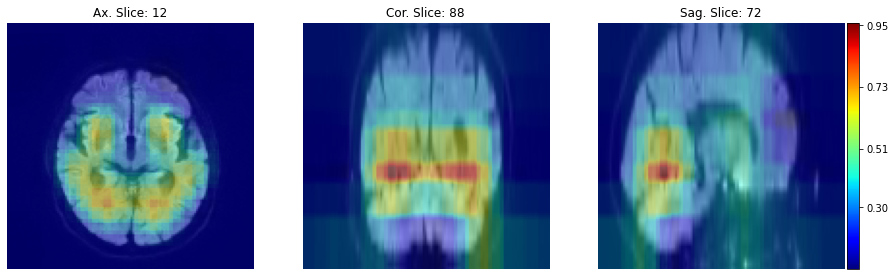

In [12]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

In [ ]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6

sl.occlusion_interactive_plot(
    162, # patient id
    occ_size = occ_size, occ_stride = occ_stride,
    cnn=model_3d, all_results=all_results, pat=pat, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_dat,
    pred_hm_only=True) # if True, only the heatmap for the predicted class is shown, otherwise also negative heatmaps are shown